# train

In [1]:
from torch.utils.data import DataLoader
import torch.nn as nn
from utils.datasets import LoadDataset
from utils import torch_utils
import time
import rtest
from tqdm import tqdm
from models import *
import os

In [2]:
# specify visible GPU
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch_utils.select_device()

Using CUDA device0 _CudaDeviceProperties(name='GeForce RTX 2070', total_memory=8192MB)


In [14]:
IMG_SIZE = 416
EPOCHES = 1
BATCH_SIZE = 1
START_EPOCH = 0
CFG = 'cfg/yolov3-tiny.cfg'
DATA_CFG = 'cfg/coco-1.data'
NUM_WORKERS = 5
FREEZE_BACKBONE = False
FROM_SCRATCH = True

weights = 'F:/Dev/weights/'
latest = os.path.join(weights, 'latest.pt')
best = os.path.join(weights, 'best.pt')

In [15]:
train_path = parse_data_cfg(DATA_CFG)['train'];train_path

'C:/coco/train1.txt'

In [16]:
# Dataset
dataset = LoadDataset(train_path, img_size=IMG_SIZE);dataset[0][0].shape

torch.Size([3, 416, 416])

In [17]:
# model
model = Darknet(CFG, IMG_SIZE).to(device)

In [18]:
# Dataloader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False, pin_memory=True, collate_fn=dataset.collate_fn)

In [8]:
cutoff = -1  # backbone reaches to cutoff layer
START_EPOCH = 0
best_loss = float('inf')

if not FROM_SCRATCH:
    if '-tiny.cfg' in CFG:
        cutoff = load_darknet_weights(model, weights + 'yolov3-tiny.conv.15')
    else:
        cutoff = load_darknet_weights(model, weights + 'darknet53.conv.74')

In [19]:
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.to(device);

In [20]:
model_info(model)


layer                                     name  gradient   parameters                shape         mu      sigma
    0                          0.conv_0.weight      True          432        [16, 3, 3, 3]   -0.00666      0.109
    1                    0.batch_norm_0.weight      True           16                 [16]      0.542      0.282
    2                      0.batch_norm_0.bias      True           16                 [16]          0          0
    3                          2.conv_2.weight      True         4608       [32, 16, 3, 3]   0.000556     0.0477
    4                    2.batch_norm_2.weight      True           32                 [32]      0.515      0.308
    5                      2.batch_norm_2.bias      True           32                 [32]          0          0
    6                          4.conv_4.weight      True        18432       [64, 32, 3, 3]   0.000279     0.0341
    7                    4.batch_norm_4.weight      True           64                 [64]     

In [21]:
# Optimizer
lr0 = 0.001  # initial learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr0, momentum=0.9, weight_decay=0.0005)

# Scheduler (reduce lr at epochs 218, 245, i.e. batches 400k, 450k)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[218, 245], gamma=0.1,
                                                 last_epoch=START_EPOCH - 1)

In [22]:
# Start training
t = time.time()
nB = len(dataloader) # num of batches
n_burnin = min(round(nB / 5 + 1), 1000)
accumulate = 1
multi_scale = False

for epoch in range(START_EPOCH, EPOCHES):
    model.train()
    print(('\n%8s%12s' + '%10s' * 7) % ('Epoch', 'Batch', 'xy', 'wh', 'conf', 'cls', 'total', 'nTargets', 'time'))

    # Update scheduler
    scheduler.step()

    mloss = torch.zeros(5).to(device) # mean losses
    for i, (imgs, targets, _, _) in enumerate(dataloader):
        imgs = imgs.to(device)
        targets = targets.to(device)
        nt = len(targets)

        # SGD burn-in
        if epoch == 0 and i <= n_burnin:
            lr = lr0 * (i / n_burnin) ** 4
            for x in optimizer.param_groups:
                x['lr'] = lr

        # Run model
        pred = model(imgs)

        # Build targets
        target_list = build_targets(model, targets)

        # Compute loss
        loss, loss_items = compute_loss(pred, target_list)

        # Compute gradient
        loss.backward()

        # Accumulate gradient for x batches before optimizing
        if (i + 1) % accumulate == 0 or (i + 1) == nB:
            optimizer.step()
            optimizer.zero_grad()

        # Update running mean of tracked metrics
        mloss = (mloss * i + loss_items) / (i + 1)

        # Print batch results
        s = ('%8s%12s' + '%10.3g' * 7) % (
            '%g/%g' % (epoch, EPOCHES - 1),
            '%g/%g' % (i, nB - 1), *mloss, nt, time.time() - t)
        t = time.time()
        print(s)

    # Calculate mAP
    with torch.no_grad():
        results = rtest.test(CFG, DATA_CFG, batch_size=BATCH_SIZE, img_size=IMG_SIZE, model=model, conf_thres=0.1)


   Epoch       Batch        xy        wh      conf       cls     total  nTargets      time
     0/0         0/0      1.37     0.539      92.2      8.85       103         8      1.62


Computing mAP: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


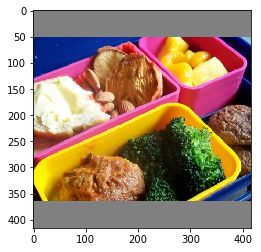

In [29]:
import matplotlib.pyplot as plt
plt.imshow(imgs[0].cpu().numpy().transpose(1, 2, 0))

In [28]:
imgs.shape

torch.Size([1, 3, 416, 416])

In [30]:
targets.shape

torch.Size([8, 6])

In [31]:
targets

tensor([[ 0.0000, 45.0000,  0.4795,  0.6416,  0.9556,  0.4466],
        [ 0.0000, 45.0000,  0.7365,  0.3104,  0.4989,  0.3573],
        [ 0.0000, 50.0000,  0.6371,  0.6747,  0.4941,  0.3829],
        [ 0.0000, 45.0000,  0.3394,  0.4392,  0.6789,  0.5861],
        [ 0.0000, 49.0000,  0.6468,  0.2244,  0.1180,  0.0727],
        [ 0.0000, 49.0000,  0.7731,  0.2224,  0.0907,  0.0729],
        [ 0.0000, 49.0000,  0.6683,  0.2952,  0.1313,  0.1102],
        [ 0.0000, 49.0000,  0.6429,  0.1844,  0.1481,  0.1110]],
       device='cuda:0')

In [33]:
pred[0].shape

torch.Size([1, 3, 13, 13, 85])

In [34]:
pred[1].shape

torch.Size([1, 3, 26, 26, 85])

In [39]:
len(target_list)

4

In [37]:
target_list[0][0]

tensor([[0.2334, 0.3405],
        [0.5747, 0.0351],
        [0.2818, 0.7711],
        [0.4127, 0.7092],
        [0.4089, 0.9174],
        [0.0509, 0.8906],
        [0.6879, 0.8373],
        [0.3572, 0.3974]], device='cuda:0')

In [38]:
target_list[0][1]

tensor([[0.8177, 0.8348],
        [0.1018, 0.7811],
        [0.3757, 0.6747],
        [0.7143, 0.7948]], device='cuda:0')